In [10]:
import pandas as pd
asset = pd.read_csv('return_data.csv')
print(asset.head())
print(len(asset))


          ID        date  Total Return  Specific Risk  20-Day ADV    Growth  \
0  11JMZFSN8  1998-01-02     -0.060465      62.171901     7467336  0.610272   
1  11JS8VT41  1998-01-02      0.000000      37.705799     4636298  1.044603   
2  11NSZA7T1  1998-01-02     -0.003540      38.329513     3920738 -0.110977   
3  122JHRL77  1998-01-02     -0.011834      25.069789       65048 -0.156014   
4  12ULRB8M7  1998-01-02      0.012552      41.183064     1436133  0.923330   

   Volatility  Profitability  Dividend Yield     Value  Market Sensitivity  \
0    1.483404      -3.348269       -1.044360 -0.796163            0.742236   
1    0.719389       0.154666       -1.044360 -0.074093           -0.014233   
2    1.101480      -0.405215       -1.044360 -3.246199           -0.743466   
3   -0.531706      -0.169127        0.406568  1.168001           -0.377473   
4    0.358930      -0.023051       -1.044360  0.564086            0.025626   

   Medium-Term Momentum  Short-Term Momentum  Liquidity 

# Part I

### a. Plot the number of assets per date. Propose a criterion to accommodate a changing estimation universe.

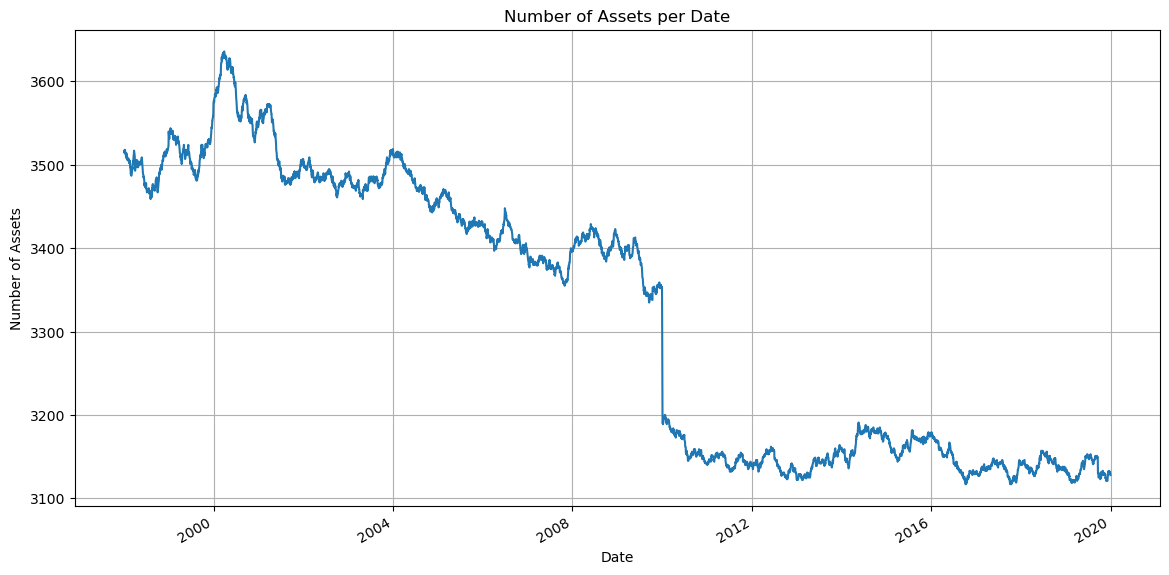

In [11]:
import matplotlib.pyplot as plt
asset['date'] = pd.to_datetime(asset['date'])

assets_per_date = asset.groupby('date').size()

plt.figure(figsize=(14, 7))
assets_per_date.plot()
plt.title('Number of Assets per Date')
plt.xlabel('Date')
plt.ylabel('Number of Assets')
plt.grid(True)
plt.show()



#### Criterion
1. Define a minimum number of data points (or a minimum period, e.g., 6 months) that an asset must have to be included in the estimation for a given period. This ensures that only assets with sufficient historical data are considered, improving the robustness of the model.

2. Use a rolling look-back window (e.g., the past 12 months) to select assets for each estimation period. This method allows the model to adapt gradually to the changing universe by including new assets that meet the minimum data points criterion and excluding those that no longer do.

3. Liquidity Threshold: Implement a liquidity filter, such as a minimum average daily volume (ADV) over the look-back period, to ensure that the assets in the model are sufficiently tradable. This criterion can be adjusted according to the model's focus and the overall market conditions.

### b. Perform a fundamental factor model using the available factors.

The dependent variable(r) is the column of total return. Independent variable matrix(X) is the remaining numeric columns. The Cross-sectional regression model is $r_{t} = B_{t}f_{t} + \epsilon_{t}$ 

In [12]:
unique_ids = asset['ID'].nunique()
print(f"There are {unique_ids} different IDs in the dataset.")

There are 9779 different IDs in the dataset.


In [13]:
asset['date'] = pd.to_datetime(asset['date'])

date_ranges = asset.groupby('ID')['date'].agg([min, max])
date_ranges['months_diff'] = ((date_ranges['max'] - date_ranges['min']) / pd.Timedelta(days=30)).round(0)

eligible_assets = date_ranges[date_ranges['months_diff'] >= 6].index

asset_new = asset[asset['ID'].isin(eligible_assets)]
print(len(asset_new))

unique_ids2 = asset_new['ID'].nunique()
print(f"There are {unique_ids2} different IDs in the new dataset.")
print(asset_new.head())

18343115
There are 9192 different IDs in the new dataset.
          ID       date  Total Return  Specific Risk  20-Day ADV    Growth  \
0  11JMZFSN8 1998-01-02     -0.060465      62.171901     7467336  0.610272   
1  11JS8VT41 1998-01-02      0.000000      37.705799     4636298  1.044603   
2  11NSZA7T1 1998-01-02     -0.003540      38.329513     3920738 -0.110977   
3  122JHRL77 1998-01-02     -0.011834      25.069789       65048 -0.156014   
4  12ULRB8M7 1998-01-02      0.012552      41.183064     1436133  0.923330   

   Volatility  Profitability  Dividend Yield     Value  Market Sensitivity  \
0    1.483404      -3.348269       -1.044360 -0.796163            0.742236   
1    0.719389       0.154666       -1.044360 -0.074093           -0.014233   
2    1.101480      -0.405215       -1.044360 -3.246199           -0.743466   
3   -0.531706      -0.169127        0.406568  1.168001           -0.377473   
4    0.358930      -0.023051       -1.044360  0.564086            0.025626   

   M

In [14]:
import statsmodels.api as sm

X = asset_new.drop(columns=['ID', 'date', 'Total Return'])
X = sm.add_constant(X)

y = asset_new['Total Return']

model = sm.OLS(y, X).fit()

coefficients = model.params

print(coefficients)


const                  -1.608186e-03
Specific Risk           7.625382e-05
20-Day ADV              7.314482e-13
Growth                 -2.941255e-06
Volatility             -7.375088e-04
Profitability           2.458308e-04
Dividend Yield          1.178584e-04
Value                  -1.373355e-04
Market Sensitivity     -1.230373e-04
Medium-Term Momentum   -8.731160e-04
Short-Term Momentum     7.483327e-03
Liquidity              -5.158778e-04
dtype: float64


### c. Plot daily turnover of each factor over time. Sort factors from lowest turnover to higher turnover and determine a cluster of lower-turnover and high-turnover factors.

In [15]:
import pandas as pd

factors = ['Specific Risk', '20-Day ADV', 'Growth', 'Volatility', 'Profitability', 'Dividend Yield', 'Value', 
           'Market Sensitivity', 'Medium-Term Momentum', 'Short-Term Momentum', 'Liquidity']

avg_daily_turnover = {}
for factor in factors:
    daily_turnover = asset_new.groupby('date')[factor].apply(lambda x: x.diff().abs().mean())
    avg_daily_turnover[factor] = daily_turnover.mean()

sorted_factors = sorted(avg_daily_turnover.items(), key=lambda x: x[1])

for factor, avg_turnover in sorted_factors:
    print(f"{factor}: {avg_turnover:.6f}")

Volatility: 0.896051
Profitability: 0.952374
Value: 0.958542
Medium-Term Momentum: 1.024628
Short-Term Momentum: 1.034476
Market Sensitivity: 1.048054
Liquidity: 1.065890
Dividend Yield: 1.082395
Growth: 1.083030
Specific Risk: 23.589966
20-Day ADV: 65712441.882743


#### The cluster of higher turnover factors: 'Specific Risk', '20-Day ADV'
#### The cluster of lower turnover factors: 'Growth', 'Volatility', 'Profitability', 'Dividend Yield', 'Value', 'Market Sensitivity', 'Medium-Term Momentum', 'Short-Term Momentum', 'Liquidity'

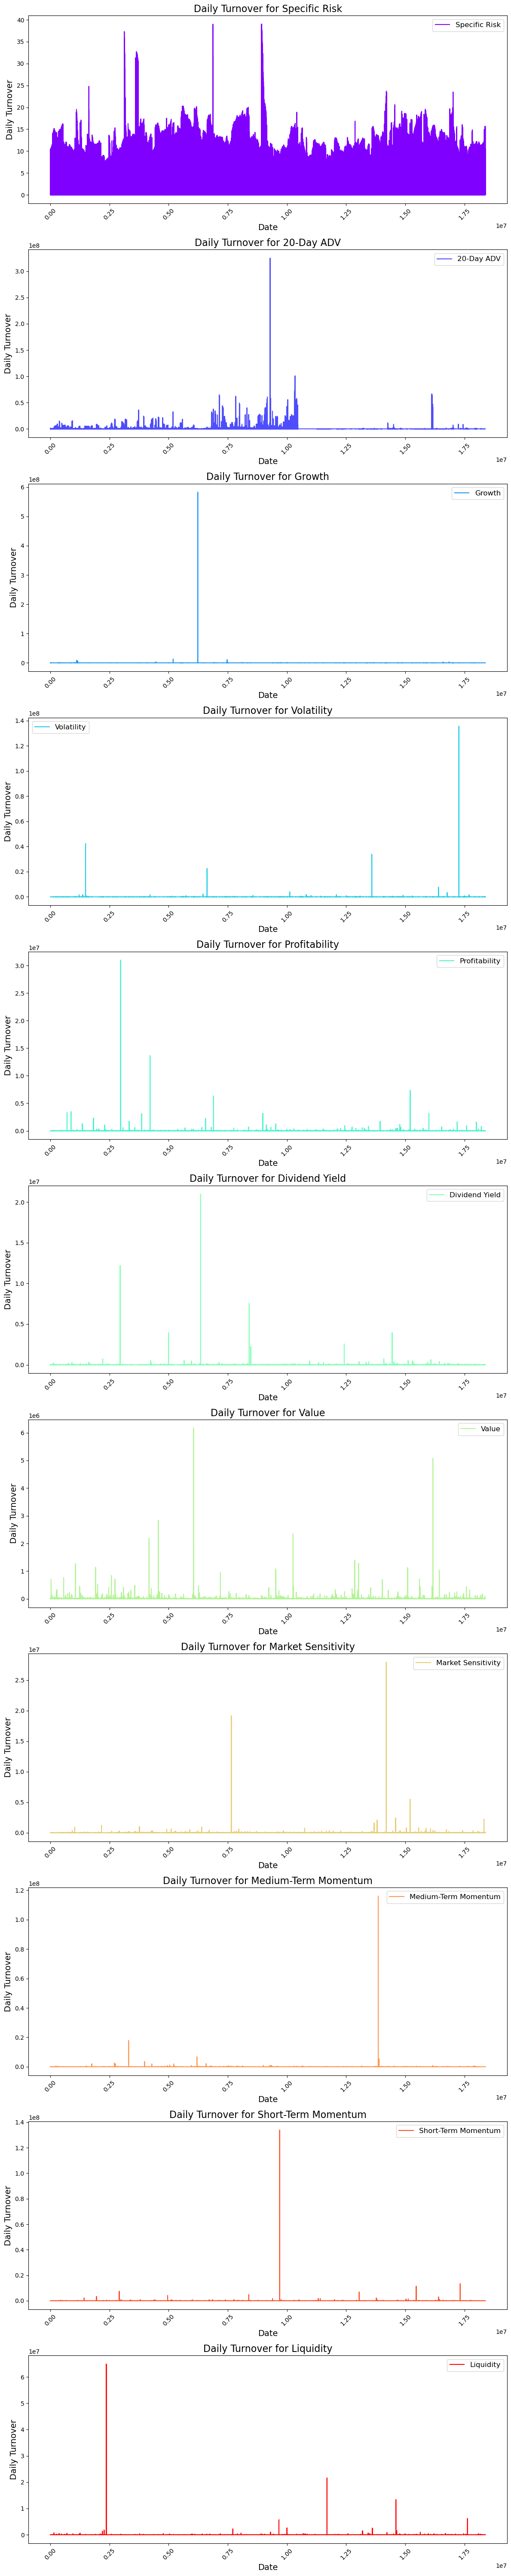

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

factors = ['Specific Risk', '20-Day ADV', 'Growth', 'Volatility', 'Profitability', 'Dividend Yield', 'Value', 'Market Sensitivity', 
           'Medium-Term Momentum', 'Short-Term Momentum', 'Liquidity']

colors = plt.cm.rainbow(np.linspace(0, 1, len(factors)))

fig, axs = plt.subplots(nrows=len(factors), ncols=1, figsize=(12, 60), sharey=False)

for i, factor in enumerate(factors):
    factor_values = asset_new[factor].replace([np.inf, -np.inf], np.nan).fillna(asset_new[factor].median())
    smoothed_values = medfilt(factor_values, kernel_size=7) 
    daily_turnover = asset_new[factor].pct_change().abs().fillna(0)
    axs[i].plot(daily_turnover.index, daily_turnover.values, color=colors[i], label=factor)
    axs[i].set_title(f'Daily Turnover for {factor}', fontsize=16)
    axs[i].legend(fontsize=12)
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel('Date', fontsize=14)
    axs[i].set_ylabel('Daily Turnover', fontsize=14)

plt.tight_layout()
plt.show()

### d. Orthogonalize high-turnover factors to lower-turnover ones.

In [26]:
if not {'ID', 'date'}.issubset(asset_new.index.names):
    asset_new.set_index(['ID', 'date'], inplace=True)

high_turnover_factors = ['Specific Risk', '20-Day ADV']
lower_turnover_factors = ['Growth', 'Volatility', 'Profitability', 'Dividend Yield', 'Value', 
                          'Market Sensitivity', 'Medium-Term Momentum', 'Short-Term Momentum', 'Liquidity']

# Orthogonalize high-turnover factors against the lower-turnover ones
orthogonal_factors = {}
for high_factor in high_turnover_factors:
    Y = asset_new[high_factor]
    X = asset_new[lower_turnover_factors]
    X = sm.add_constant(X)  
    model = sm.OLS(Y, X).fit()
    residuals = model.resid
    orthogonal_factors[high_factor + ' Orthogonal'] = residuals

# Create a DataFrame for the combined factor universe
combined_factors = pd.DataFrame(orthogonal_factors, index=asset_new.index)
for factor in lower_turnover_factors:
    combined_factors[factor] = asset_new[factor]

print(combined_factors.head())


                      Specific Risk Orthogonal  20-Day ADV Orthogonal  \
ID        date                                                          
11JMZFSN8 1998-01-02                 -7.422818          -3.408507e+07   
11JS8VT41 1998-01-02                 -1.972851          -4.941870e+07   
11NSZA7T1 1998-01-02                 -1.725250          -8.584898e+07   
122JHRL77 1998-01-02                 11.004386          -5.109433e+07   
12ULRB8M7 1998-01-02                  6.014930          -2.742312e+07   

                        Growth  Volatility  Profitability  Dividend Yield  \
ID        date                                                              
11JMZFSN8 1998-01-02  0.610272    1.483404      -3.348269       -1.044360   
11JS8VT41 1998-01-02  1.044603    0.719389       0.154666       -1.044360   
11NSZA7T1 1998-01-02 -0.110977    1.101480      -0.405215       -1.044360   
122JHRL77 1998-01-02 -0.156014   -0.531706      -0.169127        0.406568   
12ULRB8M7 1998-01-02  0.92

### e. Perform Cross-Sectional regression for the combined factor universe, plot their returns and compute Annual Returns and Sharpe Ratios. Use the specific risk in the dataset for the weights.

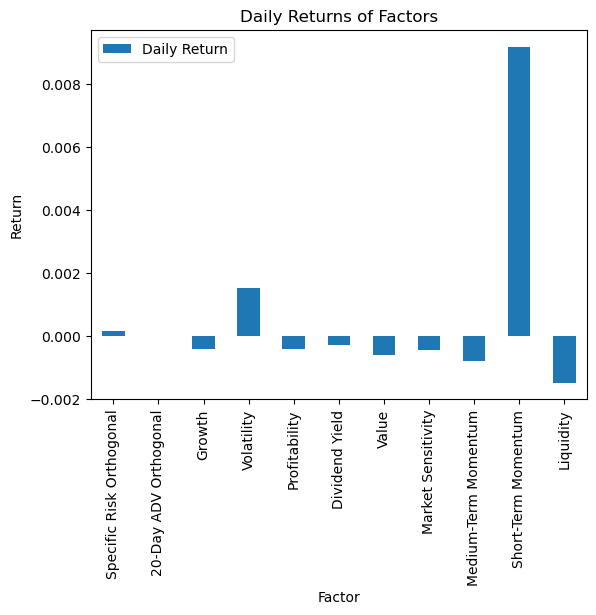

Annual Returns:
                           Daily Return
Specific Risk Orthogonal  3.850833e-02
20-Day ADV Orthogonal     6.890515e-10
Growth                   -9.968133e-02
Volatility                3.878830e-01
Profitability            -1.061758e-01
Dividend Yield           -6.825454e-02
Value                    -1.490795e-01
Market Sensitivity       -1.100173e-01
Medium-Term Momentum     -1.971601e-01
Short-Term Momentum       2.315075e+00
Liquidity                -3.730452e-01
Sharpe Ratios:
 Specific Risk Orthogonal    1.218848e-04
20-Day ADV Orthogonal       2.717444e-19
Growth                     -6.282790e-03
Volatility                  2.895319e-02
Profitability              -7.155205e-03
Dividend Yield             -3.538738e-03
Value                      -9.991653e-03
Market Sensitivity         -6.988743e-03
Medium-Term Momentum       -1.246690e-02
Short-Term Momentum         1.460987e-01
Liquidity                  -2.354956e-02
dtype: float64


In [28]:
factor_returns = {}
for factor in combined_factors.columns:
    Y = asset_new['Total Return']  
    X = combined_factors[[factor]] 
    X = sm.add_constant(X) 
    if X.dropna().empty:
        print(f"Insufficient data for regression on {factor}")
        continue
    model = sm.WLS(Y, X, weights=asset_new['Specific Risk'], missing='drop').fit()  # Weight by Specific Risk, drop NaNs
    factor_returns[factor] = model.params[factor] 

factor_returns_df = pd.DataFrame.from_dict(factor_returns, orient='index', columns=['Daily Return'])

factor_returns_df.plot(kind='bar')
plt.title('Daily Returns of Factors')
plt.xlabel('Factor')
plt.ylabel('Return')
plt.show()

# Calculation of Annual Returns and Sharpe Ratios
annual_returns = factor_returns_df * 252 
daily_volatility = combined_factors.std()
annual_volatility = daily_volatility * np.sqrt(252)

sharpe_ratios = annual_returns['Daily Return'] / annual_volatility.replace(0, np.nan)

print("Annual Returns:\n", annual_returns)
print("Sharpe Ratios:\n", sharpe_ratios)


# Part II

### a. Implement a QLIKE Test statistic based on Random Portfolios.

In [34]:
np.random.seed(42)
returns = np.random.normal(0, 0.01, (100, 10))
weights = np.random.dirichlet(np.ones(10), 50)
realized_volatility = np.std(np.dot(returns, weights.T), axis=0)

forecast_volatility_model1 = np.random.normal(0.01, 0.005, 50)
forecast_volatility_model2 = np.random.normal(0.01, 0.005, 50)

def qlike_statistic(realized, forecast):
    return np.sum((realized**2 / forecast**2) + np.log(forecast**2))

qlike_model1 = qlike_statistic(realized_volatility, forecast_volatility_model1)
qlike_model2 = qlike_statistic(realized_volatility, forecast_volatility_model2)

print("QLIKE Model 1:", qlike_model1)
print("QLIKE Model 2:", qlike_model2)


QLIKE Model 1: 46.92311568119408
QLIKE Model 2: -426.2681358597154


### b. Implement Minimum Variance Portfolios tests.

In [37]:
from scipy.optimize import minimize

np.random.seed(42)
returns = np.random.normal(0, 0.01, (250, 5))
cov_matrix = np.cov(returns, rowvar=False)

def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

num_assets = returns.shape[1]
initial_weights = np.ones(num_assets) / num_assets

bounds = tuple((0, 1) for asset in range(num_assets))
result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = result.x

print("Optimized Portfolio Weights:", optimized_weights)


Optimized Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]


### c. Estimate factor covariance matrix and idio vols. Try different half-lives.

In [38]:
import numpy as np
import pandas as pd

def ewma_covariance(matrix, lambda_):
    """
    Calculate the EWMA covariance matrix.
    """
    decay_factors = lambda_ ** np.arange(len(matrix))[::-1]
    weights = decay_factors / decay_factors.sum()
    sample_cov = np.cov(matrix, rowvar=False, aweights=weights)
    return sample_cov

np.random.seed(0)
factor_returns = np.random.normal(0, 0.01, (250, 3))  # 250 days, 3 factors
asset_returns = np.random.normal(0, 0.01, (250, 10))  # 250 days, 10 assets

# Calculate factor loadings and residuals
loadings = np.linalg.lstsq(factor_returns, asset_returns, rcond=None)[0]
residuals = asset_returns - np.dot(factor_returns, loadings)

half_lives = [30, 60, 120] 
factor_covariances = {}
idio_vols = {}

for hl in half_lives:
    lambda_ = 0.5 ** (1 / hl)
    factor_covariances[hl] = ewma_covariance(factor_returns, lambda_)
    idio_vols[hl] = np.diag(ewma_covariance(residuals, lambda_))

print("Factor Covariances:", factor_covariances)
print("Idiosyncratic Volatilities:", idio_vols)


Factor Covariances: {30: array([[ 1.07477518e-04, -1.09076393e-05, -1.48704811e-05],
       [-1.09076393e-05,  1.09848740e-04, -1.39971734e-05],
       [-1.48704811e-05, -1.39971734e-05,  9.99297930e-05]]), 60: array([[ 1.05536268e-04, -7.32632442e-06, -7.33608454e-06],
       [-7.32632442e-06,  1.06709580e-04, -1.04780658e-05],
       [-7.33608454e-06, -1.04780658e-05,  9.71857326e-05]]), 120: array([[ 1.04979307e-04, -5.79415055e-06, -2.20276845e-06],
       [-5.79415055e-06,  1.04954340e-04, -7.95291270e-06],
       [-2.20276845e-06, -7.95291270e-06,  9.58029048e-05]])}
Idiosyncratic Volatilities: {30: array([1.02770955e-04, 9.29769045e-05, 1.06308553e-04, 8.72809872e-05,
       9.23543904e-05, 8.34734237e-05, 7.87833870e-05, 8.86837666e-05,
       1.08676274e-04, 1.03908652e-04]), 60: array([9.88359029e-05, 9.20734095e-05, 1.02849234e-04, 8.92238786e-05,
       9.14848980e-05, 8.56481099e-05, 8.10967123e-05, 8.95334385e-05,
       1.05633261e-04, 9.62860443e-05]), 120: array([9.747

### d. Test the performance of the model under the QLIKE, MSE and Min Variance Portfolios for the first cluster, and then the second cluster.  

In [45]:
import pandas as pd
import numpy as np

def calculate_qlke(actual, predicted):
    epsilon = 1e-8 
    return np.mean((actual - predicted)**2 / (predicted + epsilon))

def calculate_mse(actual, predicted):
    return np.mean((actual - predicted)**2)

def min_variance_portfolio(returns):
    cov_matrix = returns.cov()
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse to handle singularity
    weights = inv_cov_matrix.sum(axis=1) / inv_cov_matrix.sum().sum()
    return pd.Series(weights, index=returns.columns)

predicted_returns_high = combined_factors[high_turnover_factors].dot(factor_returns_df.loc[high_turnover_factors, 'Daily Return'])
predicted_returns_low = combined_factors[lower_turnover_factors].dot(factor_returns_df.loc[lower_turnover_factors, 'Daily Return'])

# Calculate QLIKE, MSE, and Min Variance Portfolio for each cluster
qlke_high = calculate_qlke(asset_new['Total Return'], predicted_returns_high)
mse_high = calculate_mse(asset_new['Total Return'], predicted_returns_high)
qlke_low = calculate_qlke(asset_new['Total Return'], predicted_returns_low)
mse_low = calculate_mse(asset_new['Total Return'], predicted_returns_low)

weights_high = min_variance_portfolio(combined_factors[high_turnover_factors])
weights_low = min_variance_portfolio(combined_factors[lower_turnover_factors])

print(f"High Turnover Factors - QLIKE: {qlke_high}, MSE: {mse_high}")
print(f"Low Turnover Factors - QLIKE: {qlke_low}, MSE: {mse_low}")
print(f"Min Variance Portfolio Weights - High Turnover:\n{weights_high}")
print(f"Min Variance Portfolio Weights - Low Turnover:\n{weights_low}")


High Turnover Factors - QLIKE: 3.6500238182597755, MSE: 0.06659401352100891
Low Turnover Factors - QLIKE: 1.327556604267171, MSE: 0.0665435578131742
Min Variance Portfolio Weights - High Turnover:
Specific Risk Orthogonal    1.000000e+00
20-Day ADV Orthogonal       6.901442e-09
dtype: float64
Min Variance Portfolio Weights - Low Turnover:
Growth                  0.070441
Volatility              0.215204
Profitability           0.130928
Dividend Yield          0.110423
Value                   0.125871
Market Sensitivity      0.136543
Medium-Term Momentum    0.104508
Short-Term Momentum     0.075856
Liquidity               0.030226
dtype: float64


### e. Optional: apply shrinkage to covariance matrix, dynamic vol adjustment, and Newey-West correction.